## Phase 3 : Modélisation, entraînement et optimisation des modèles de régression

### Configuration

In [24]:
import seaborn as sns 
import matplotlib as plt
import pandas as pd
import numpy as np
import pickle

DATA_PATH = "../data/"
RAW_FILE = DATA_PATH + "raw/insurance.csv"
CLEAN_FILE = DATA_PATH + "process/insurance_clean.csv"
OUTPUT_PATH = "../output/"
ENCODAGE_FILE = OUTPUT_PATH + "pickle/encoders.pkl"
TRAINING_FILE = OUTPUT_PATH + "pickle/model.pkl"
COLUMN_FILE = OUTPUT_PATH + "pickle/columns.pkl"

In [2]:
df = pd.read_csv(CLEAN_FILE, sep=",", header=0)

### Division des données

In [3]:
from sklearn.model_selection import train_test_split

features = df.drop(["expenses", "log_expenses"], axis = 1) # Variable explicatif
target = df["log_expenses"] # Variable cible transformée

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Selection de modèle de régression

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

# Initialiser les modèles
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42, force_col_wise=True)
}

# Stocker les performances des modèles
metrics = {
    "Model": [],
    "Mean Absolute Error (MAE)": [],
    "Mean Squared Error (MSE)": [],
    "R2 Score": []
}
# Validation croisée
cv = 5  # Nombre de plis de la validation croisée

# Évaluer chaque modèle avec la validation croisée
for name, model in models.items():
    print(f"Évaluation du modèle : {name}")
    
    # Calculer les scores pour chaque métrique avec cross_val_score
    mse_scores = -cross_val_score(model, features, target, scoring="neg_mean_squared_error", cv=cv)
    mae_scores = -cross_val_score(model, features, target, scoring="neg_mean_absolute_error", cv=cv)
    r2_scores = cross_val_score(model, features, target, scoring="r2", cv=cv)
    
    # Calculer les moyennes des métriques
    metrics["Model"].append(name)
    metrics["Mean Absolute Error (MAE)"].append(np.mean(mae_scores))
    metrics["Mean Squared Error (MSE)"].append(np.mean(mse_scores))
    metrics["R2 Score"].append(np.mean(r2_scores))

# Convertir les métriques en DataFrame pour un affichage clair
metrics_df = pd.DataFrame(metrics)
metrics_df

Évaluation du modèle : Linear Regression
Évaluation du modèle : Ridge Regression
Évaluation du modèle : Lasso Regression
Évaluation du modèle : Random Forest
Évaluation du modèle : Support Vector Regressor
Évaluation du modèle : XGBoost
Évaluation du modèle : LightGBM
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 1063, number of used features: 9
[LightGBM] [Info] Start training from score 9.097237
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 1063, number of used features: 9
[LightGBM] [Info] Start training from score 9.095902
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 1063, number of used features: 9
[LightGBM] [Info] Start training from score 9.105652
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 1063, number of used features: 9
[LightGBM] [Info] Start training from score 9.096591
[LightGBM] [Info] Total

,Model,Mean Absolute Error (MAE),Mean Squared Error (MSE),R2 Score
0,Linear Regression,0.280584,0.198758,0.762937
1,Ridge Regression,0.280899,0.198772,0.762919
2,Lasso Regression,0.368981,0.272033,0.675173
3,Random Forest,0.202803,0.160813,0.808205
4,Support Vector Regressor,0.455811,0.618015,0.262888
5,XGBoost,0.243842,0.197779,0.765060
6,LightGBM,0.215887,0.156385,0.813457


Le modèle **Random Forest** est choisi pour sa **meilleure performance globale** parmi les modèles testés, avec un **MAE (0.2028)** et un **MSE (0.1608)** faibles, ainsi qu'un **R² élevé (0.8082)**. Il offre un bon équilibre entre précision et robustesse, tout en étant capable de capturer des relations complexes dans les données.

### Optimisation des hyperparamètres

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Définir les hyperparamètres à tester
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # Remplacer 'auto' par None
}

# Initialiser le modèle
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Nombre d'itérations à tester
    cv=5,  # Validation croisée
    scoring='neg_mean_squared_error',  # Métrique d'évaluation
    random_state=42,
    n_jobs=-1  # Utiliser tous les cœurs disponibles
)

# Entraîner le modèle avec RandomizedSearchCV
random_search.fit(features_train, target_train)

# Meilleurs hyperparamètres trouvés
print("Best Hyperparameters:", random_search.best_params_)

# Modèle optimisé
best_rf = random_search.best_estimator_

# Prédictions sur le jeu de test
y_pred = best_rf.predict(features_test)

# Évaluer les métriques
print("MAE:", mean_absolute_error(target_test, y_pred))
print("MSE:", mean_squared_error(target_test, y_pred))
print("R2 Score:", r2_score(target_test, y_pred))

Best Hyperparameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 20}
MAE: 0.19671103278849802
MSE: 0.1757655851207517
R2 Score: 0.7768171406827596


### Validation croisée

Par défaut, on a utilisé la validation croisée `K-fold`. On va tester les modèles sur d'autres validations croisées.

#### a. LOOCV

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Définir les hyperparamètres à tester
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # Remplacer 'auto' par None
}


# Initialiser Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Initialiser le modèle
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Nombre d'itérations à tester
    cv=loo,  # Validation croisée
    scoring='neg_mean_squared_error',  # Métrique d'évaluation
    random_state=42,
    n_jobs=-1  # Utiliser tous les cœurs disponibles
)

# Entraîner le modèle avec RandomizedSearchCV
random_search.fit(features_train, target_train)

# Meilleurs hyperparamètres trouvés
print("Best Hyperparameters:", random_search.best_params_)

# Modèle optimisé
best_rf = random_search.best_estimator_

# Prédictions sur le jeu de test
y_pred = best_rf.predict(features_test)

# Évaluer les métriques
print("MAE:", mean_absolute_error(target_test, y_pred))
print("MSE:", mean_squared_error(target_test, y_pred))
print("R2 Score:", r2_score(target_test, y_pred))

KeyboardInterrupt: 

**LOOCV** est trop long à exécuter. Cette méthode ne sera pas choisi

#### b. Stratified K-fold

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Définir les hyperparamètres à tester
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Catégorisation (binning) de la variable cible `target`
n_bins = 5
y_binned = pd.qcut(target, q=n_bins, labels=False)

# Initialiser StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialiser le modèle
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV avec StratifiedKFold
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=skf.split(features, y_binned),  # Utiliser y_binned pour stratification
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Entraîner le modèle avec RandomizedSearchCV
random_search.fit(features, target)

# Meilleurs hyperparamètres trouvés
print("Best Hyperparameters:", random_search.best_params_)

# Modèle optimisé
best_rf = random_search.best_estimator_

# Prédictions sur le jeu de test
y_pred = best_rf.predict(features_test)

# Évaluer les métriques
print("MAE:", mean_absolute_error(target_test, y_pred))
print("MSE:", mean_squared_error(target_test, y_pred))
print("R2 Score:", r2_score(target_test, y_pred))

Best Hyperparameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 20}
MAE: 0.14863650537400253
MSE: 0.10436719384049951
R2 Score: 0.8674770790639306


J'ai choisi d'utiliser la validation croisée stratifiée pour garantir une répartition équilibrée des catégories de la cible dans chaque pli, ce qui permet une évaluation plus robuste et représentative des performances du modèle. Avec les hyperparamètres optimaux, mon modèle Random Forest atteint un R² de **0.867**, confirmant sa capacité à généraliser efficacement.

In [22]:
from sklearn.model_selection import cross_val_score

# Initialiser le modèle avec les meilleurs hyperparamètres
final_model = RandomForestRegressor(
    n_estimators=400,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features=None,
    max_depth=20,
    random_state=42
)

# Catégorisation (binning) de la variable cible `target`
n_bins = 5
y_binned = pd.qcut(target, q=n_bins, labels=False)

# Validation croisée stratifiée
final_scores = cross_val_score(
    final_model, features, target, cv=skf.split(features, y_binned), scoring='neg_mean_squared_error', n_jobs=-1
)

# Afficher les métriques
mse_scores = -final_scores  # Convertir les scores négatifs en MSE
print("Mean MSE:", np.mean(mse_scores))
print("Std MSE:", np.std(mse_scores))
print("R² Final:", final_model.fit(features, target).score(features_test, target_test))


Mean MSE: 0.14624715949064643
Std MSE: 0.020136754711565584
R² Final: 0.8674770790639306


## Phase 4 : Évaluation des modèles

Après avoir validé les hyperparamètres du modèle Random Forest avec une validation croisée stratifiée et obtenu de bonnes performances sur les métriques principales (R² : **0.867**, MAE : **0.1486**, RMSE : **0.3231**), il me reste à visualiser les résultats pour confirmer la répartition des erreurs et la capacité du modèle à prédire les dépenses médicales. Cette étape inclura l'analyse des résidus et la comparaison entre les valeurs prédites et réelles pour évaluer l'ajustement global du modèle.

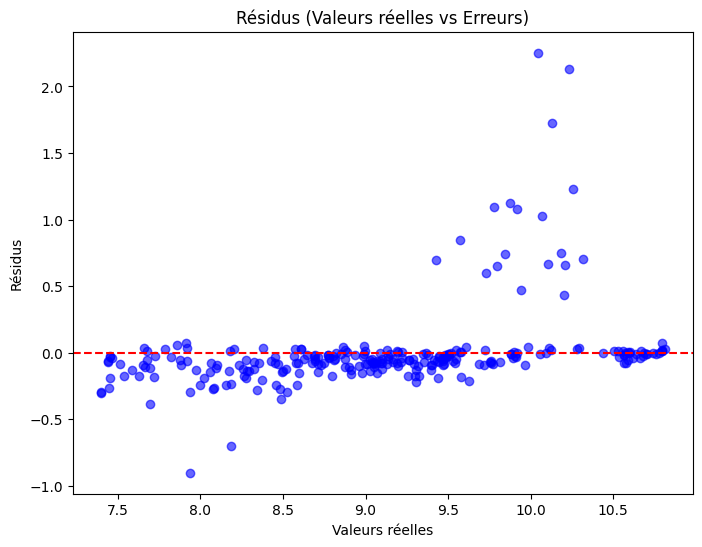

In [27]:
import matplotlib.pyplot as plt

y_pred = final_model.predict(features_test)

# Résidus (différence entre valeurs réelles et prédites)
residuals = target_test - y_pred

# Scatter plot des résidus
plt.figure(figsize=(8, 6))
plt.scatter(target_test, residuals, alpha=0.6, color="blue")
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus (Valeurs réelles vs Erreurs)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Résidus")
plt.show()

**Analyse des résidus :**
- Répartition autour de zéro :
    - La majorité des points semblent proches de la ligne rouge (résidu = 0), ce qui indique que les prédictions sont globalement précises.
    - Cela montre que le modèle capte bien les tendances générales.
- Écarts dans les valeurs élevées :
    - Les résidus augmentent pour certaines valeurs réelles élevées, ce qui peut indiquer que le modèle sous-estime légèrement les dépenses médicales les plus élevées.
- Distribution globale :
    - Les résidus semblent relativement aléatoires, ce qui est un bon signe (pas de structure systématique visible).
    - Cependant, quelques points éloignés de la ligne rouge pourraient correspondre à des outliers ou des cas difficiles à modéliser.

## Phase 5 : Interprétation des résultats et recommandations business

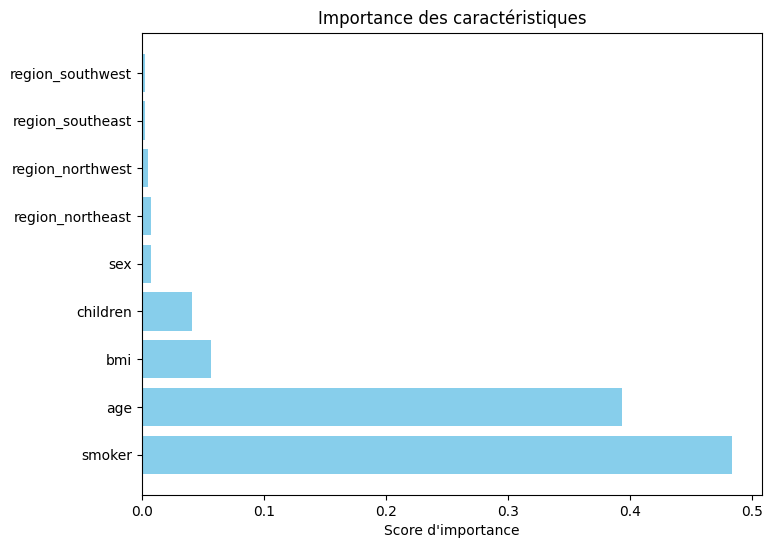

In [28]:
import matplotlib.pyplot as plt

# Importance des caractéristiques
importances = final_model.feature_importances_
feature_names = features.columns

# Tri par importance
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx], color='skyblue')
plt.title("Importance des caractéristiques")
plt.xlabel("Score d'importance")
plt.show()

Le modèle `Random Forest` met en évidence que les deux variables les plus influentes sur les dépenses médicales sont le **statut de fumeur** et **l'âge**. Les fumeurs ont un impact particulièrement significatif, confirmant que le tabagisme est un facteur clé des coûts médicaux élevés. Les autres variables, comme le **BMI** (indice de masse corporelle), jouent également un rôle, bien qu'elles soient moins déterminantes. Les variables régionales, le sexe et le nombre d'enfants ont un effet négligeable.

Recommandations business :
- **Focus sur les fumeurs** : Prioriser des campagnes anti-tabac et proposer des incitations financières pour réduire le tabagisme. Cela pourrait significativement diminuer les coûts médicaux.
- **Groupes d'âge ciblés** : Mettre en place des politiques de prévention adaptées aux populations âgées, comme des bilans de santé réguliers.
- **Prévention liée au BMI** : Développer des programmes pour sensibiliser à l'obésité et encourager des habitudes de vie saines, avec un potentiel impact positif sur les coûts.
- **Optimisation des ressources** : Réorienter les efforts marketing ou les interventions vers les groupes les plus à risque identifiés (fumeurs et personnes âgées) pour maximiser l'impact des initiatives.

## Phase 6 : Exportation et utilisation du modèle final

In [29]:
with open(COLUMN_FILE, 'wb') as file:
    pickle.dump(features.columns.to_list(), file)

with open(TRAINING_FILE, 'wb') as file:
    pickle.dump(best_rf, file)